# Installing CuPy

Follow their [docs](https://docs.cupy.dev/en/stable/install.html) to install

For myself I installed cuda-toolkit 12.8.1 through conda and then pip installed `cupy-cuda12x`

## Verify Install

In [21]:
import numpy as np
import cupy as cp

In [22]:
x_cpu = np.array([1, 2, 3])
l2_cpu = np.linalg.norm(x_cpu)

In [23]:
x_gpu = cp.array([1, 2, 3])
l2_gpu = cp.linalg.norm(x_gpu)

# Benchmark Test

In [24]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

def benchmark_operation(operation_name, numpy_func, cupy_func, sizes):
    """
    Benchmark a specific operation across different data sizes.
    
    Args:
        operation_name: Name of the operation
        numpy_func: Function that performs the operation with NumPy
        cupy_func: Function that performs the operation with CuPy
        sizes: List of data sizes to test
    
    Returns:
        Dictionary with timing results
    """
    results = {
        'sizes': sizes,
        'numpy_times': [],
        'cupy_times': [],
        'speedup': []
    }
    
    print(f"\n{'='*60}")
    print(f"Benchmarking: {operation_name}")
    print(f"{'='*60}")
    print(f"{'Size':<15} {'NumPy (ms)':<15} {'CuPy (ms)':<15} {'Speedup':<15}")
    print(f"{'-'*60}")
    
    for size in sizes:
        # NumPy timing
        start = time.time()
        _ = numpy_func(size)
        numpy_time = (time.time() - start) * 1000  # Convert to milliseconds
        
        # CuPy timing (with warm-up)
        _ = cupy_func(size)  # Warm-up run
        cp.cuda.Stream.null.synchronize()  # Wait for GPU to finish
        
        start = time.time()
        _ = cupy_func(size)
        cp.cuda.Stream.null.synchronize()  # Wait for GPU to finish
        cupy_time = (time.time() - start) * 1000  # Convert to milliseconds
        
        speedup = numpy_time / cupy_time
        
        results['numpy_times'].append(numpy_time)
        results['cupy_times'].append(cupy_time)
        results['speedup'].append(speedup)
        
        print(f"{size:<15} {numpy_time:<15.2f} {cupy_time:<15.2f} {speedup:<15.2f}x")
    
    return results


# Define benchmark operations
def matrix_multiply_numpy(size):
    a = np.random.rand(size, size).astype(np.float32)
    b = np.random.rand(size, size).astype(np.float32)
    return np.dot(a, b)

def matrix_multiply_cupy(size):
    a = cp.random.rand(size, size, dtype=cp.float32)
    b = cp.random.rand(size, size, dtype=cp.float32)
    return cp.dot(a, b)

def element_wise_numpy(size):
    a = np.random.rand(size, size).astype(np.float32)
    b = np.random.rand(size, size).astype(np.float32)
    return a * b + np.sin(a) + np.cos(b)

def element_wise_cupy(size):
    a = cp.random.rand(size, size, dtype=cp.float32)
    b = cp.random.rand(size, size, dtype=cp.float32)
    return a * b + cp.sin(a) + cp.cos(b)

def reduction_numpy(size):
    a = np.random.rand(size, size).astype(np.float32)
    return np.sum(a), np.mean(a), np.std(a)

def reduction_cupy(size):
    a = cp.random.rand(size, size, dtype=cp.float32)
    return cp.sum(a), cp.mean(a), cp.std(a)

In [25]:
# Test with different sizes
sizes = [100, 500, 1000, 5000, 10_000]

# Run different benchmarks
results_matmul = benchmark_operation(
    "Matrix Multiplication (NxN × NxN)",
    matrix_multiply_numpy,
    matrix_multiply_cupy,
    sizes
)

results_elementwise = benchmark_operation(
    "Element-wise Operations (a*b + sin(a) + cos(b))",
    element_wise_numpy,
    element_wise_cupy,
    sizes
)

results_reduction = benchmark_operation(
    "Reduction Operations (sum, mean, std)",
    reduction_numpy,
    reduction_cupy,
    sizes
)


Benchmarking: Matrix Multiplication (NxN × NxN)
Size            NumPy (ms)      CuPy (ms)       Speedup        
------------------------------------------------------------
100             0.48            0.06            7.53           x
500             18.70           0.08            242.89         x
1000            26.31           0.09            289.68         x
5000            387.30          3.93            98.62          x
10000           1841.61         32.75           56.23          x

Benchmarking: Element-wise Operations (a*b + sin(a) + cos(b))
Size            NumPy (ms)      CuPy (ms)       Speedup        
------------------------------------------------------------
100             0.25            0.09            2.78           x
500             2.39            0.08            28.92          x
1000            7.61            0.06            118.19         x
5000            302.24          1.15            263.06         x
10000           1197.23         5.63            212.5


PERFORMANCE SUMMARY

Average Speedups (CuPy vs NumPy):
  • Matrix Multiplication:  139.0x faster
  • Element-wise Ops:       125.1x faster
  • Reduction Ops:          5.6x faster

Maximum Speedup Achieved:   289.7x

Benchmark complete! Graph saved as 'cupy_vs_numpy_benchmark.png'


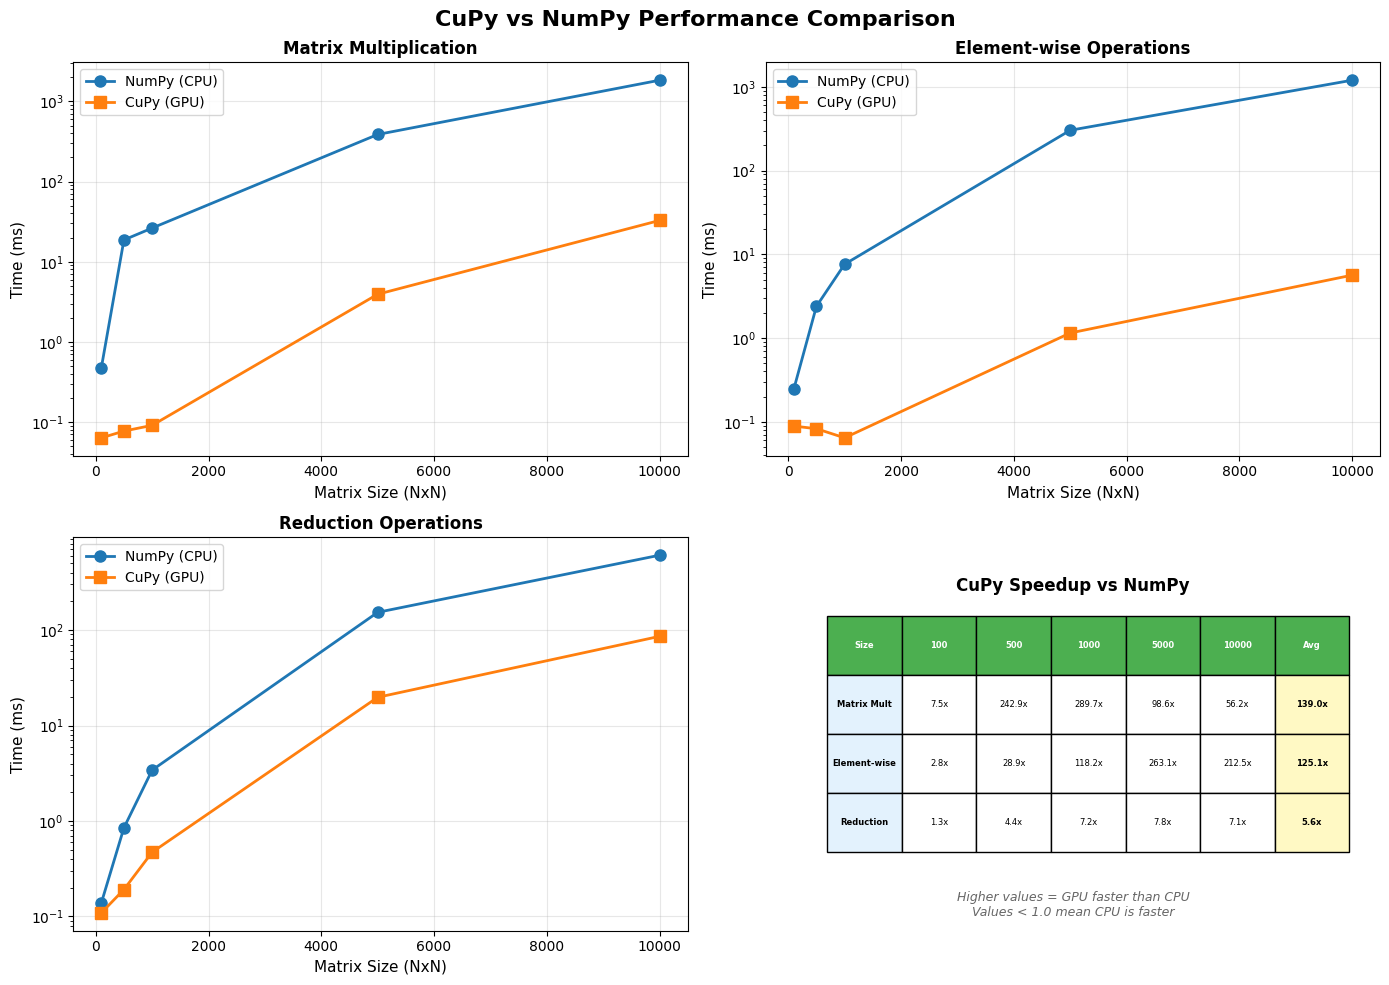

In [26]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('CuPy vs NumPy Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: Matrix Multiplication Time
ax1 = axes[0, 0]
ax1.plot(results_matmul['sizes'], results_matmul['numpy_times'], 
            'o-', label='NumPy (CPU)', linewidth=2, markersize=8)
ax1.plot(results_matmul['sizes'], results_matmul['cupy_times'], 
            's-', label='CuPy (GPU)', linewidth=2, markersize=8)
ax1.set_xlabel('Matrix Size (NxN)', fontsize=11)
ax1.set_ylabel('Time (ms)', fontsize=11)
ax1.set_title('Matrix Multiplication', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Element-wise Operations Time
ax2 = axes[0, 1]
ax2.plot(results_elementwise['sizes'], results_elementwise['numpy_times'], 
            'o-', label='NumPy (CPU)', linewidth=2, markersize=8)
ax2.plot(results_elementwise['sizes'], results_elementwise['cupy_times'], 
            's-', label='CuPy (GPU)', linewidth=2, markersize=8)
ax2.set_xlabel('Matrix Size (NxN)', fontsize=11)
ax2.set_ylabel('Time (ms)', fontsize=11)
ax2.set_title('Element-wise Operations', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Plot 3: Reduction Operations Time (NEW LINE PLOT)
ax3 = axes[1, 0]
ax3.plot(results_reduction['sizes'], results_reduction['numpy_times'], 
            'o-', label='NumPy (CPU)', linewidth=2, markersize=8, color='#1f77b4')
ax3.plot(results_reduction['sizes'], results_reduction['cupy_times'], 
            's-', label='CuPy (GPU)', linewidth=2, markersize=8, color='#ff7f0e')
ax3.set_xlabel('Matrix Size (NxN)', fontsize=11)
ax3.set_ylabel('Time (ms)', fontsize=11)
ax3.set_title('Reduction Operations', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Speedup Comparison Table
ax4 = axes[1, 1]
ax4.axis('off')

# Prepare table data
table_data = []
table_data.append(['Size'] + [str(s) for s in sizes])
table_data.append(['Matrix Mult'] + [f'{s:.1f}x' for s in results_matmul['speedup']])
table_data.append(['Element-wise'] + [f'{s:.1f}x' for s in results_elementwise['speedup']])
table_data.append(['Reduction'] + [f'{s:.1f}x' for s in results_reduction['speedup']])

# Calculate averages for the last column
avg_matmul = np.mean(results_matmul['speedup'])
avg_elementwise = np.mean(results_elementwise['speedup'])
avg_reduction = np.mean(results_reduction['speedup'])

# Add average column
for i, row in enumerate(table_data):
    if i == 0:
        row.append('Avg')
    elif i == 1:
        row.append(f'{avg_matmul:.1f}x')
    elif i == 2:
        row.append(f'{avg_elementwise:.1f}x')
    elif i == 3:
        row.append(f'{avg_reduction:.1f}x')

# Create table
table = ax4.table(cellText=table_data, 
                    cellLoc='center',
                    loc='center',
                    bbox=[0.1, 0.2, 0.85, 0.6])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1, 2.5)

# Color header row
for i in range(len(table_data[0])):
    cell = table[(0, i)]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(weight='bold', color='white')

# Color operation names (first column)
for i in range(1, len(table_data)):
    cell = table[(i, 0)]
    cell.set_facecolor('#E3F2FD')
    cell.set_text_props(weight='bold')

# Color average column
for i in range(len(table_data)):
    cell = table[(i, len(table_data[0])-1)]
    if i == 0:
        cell.set_facecolor('#4CAF50')
    else:
        cell.set_facecolor('#FFF9C4')
        cell.set_text_props(weight='bold')

# Add title above table
ax4.text(0.5, 0.9, 'CuPy Speedup vs NumPy', 
            ha='center', va='top', fontsize=12, fontweight='bold',
            transform=ax4.transAxes)

# Add note below table
note_text = "Higher values = GPU faster than CPU\nValues < 1.0 mean CPU is faster"
ax4.text(0.5, 0.1, note_text, 
            ha='center', va='top', fontsize=9, style='italic',
            transform=ax4.transAxes, color='#666666')

plt.tight_layout()
plt.savefig('cupy_vs_numpy_benchmark.png', dpi=300, bbox_inches='tight')

# Print summary statistics
avg_speedup_matmul = np.mean(results_matmul['speedup'])
avg_speedup_elementwise = np.mean(results_elementwise['speedup'])
avg_speedup_reduction = np.mean(results_reduction['speedup'])
max_speedup = max(max(results_matmul['speedup']), 
                    max(results_elementwise['speedup']),
                    max(results_reduction['speedup']))

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"\nAverage Speedups (CuPy vs NumPy):")
print(f"  • Matrix Multiplication:  {avg_speedup_matmul:.1f}x faster")
print(f"  • Element-wise Ops:       {avg_speedup_elementwise:.1f}x faster")
print(f"  • Reduction Ops:          {avg_speedup_reduction:.1f}x faster")
print(f"\nMaximum Speedup Achieved:   {max_speedup:.1f}x")
print("\n" + "="*60)
print("Benchmark complete! Graph saved as 'cupy_vs_numpy_benchmark.png'")
print("="*60)
plt.show()